In [13]:
import sys
sys.path.append('../')

In [14]:
from data_loading import ChatHighlightData
import numpy as np
from datetime import datetime
import json

from utils import moving_avg

from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from ScipyPeaks import ScipyPeaks
from RealTimePeakPredictor import RealTimePeakPredictor

from analysis import load_chat, load_highlights, remove_missing_matches, cut_same_length
import re
import numpy as np
import pandas as pd

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from zeugma.embeddings import EmbeddingTransformer

import plotly.express as px


2022-08-10 11:39:36.504176: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-10 11:39:36.504239: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## "Best" Parameter settings per baseline (Grid search with cross validation or default params)

|baseline|preprocessing|parameters|training_scores|
|--------|-------------|----------|--------------:|
|SPP|MinMaxScaler per match, mvg_avg: N=1500|prominence: 0.14 rel_height: 0.7 width: [600, 5000] shift: 0.3|f: 0.195303 (on val partition)|
|SPP in interactive viz| MinMaxScaler per match, mvg_avg: N=1500, scale:1 | prominence: 0.2 rel_height: 0.35 width: [600, 5000] shift: 0.9 width_scale:0.8| f: 0.32525 (on test+val partition)|
|SPP in pipeline|'measure': 'message_density', 'step': 20 (scale), 'window': 150, MinMaxScaler mvg_avg=50| prominence: 0.5, rel_height: 0.6, clf__shift: 0.3, width: [5, 2000]|f: 0.146922 (on val partition)|
|RTPP in pipeline|'measure': 'message_density', 'step': 40 (scale), 'window': 200, MinMaxScaler mvg_avg=5| influence: 0.7, lag: 35, threshold: 2| f:0.220860 (on val partition)|
|text TFIDF > multiNB|documents: all comments in 7 sec window (non-overlapping) concatenated|default params|p: 0.25 r: 0.60 f: 0.36 (on val partition)|
|text TFIDF > multiNB|documents: all comments in 7 sec window (non-overlapping) concatenated|'clf__alpha': 0.001, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)|p:0.30, r:0.25 f:0.27 (on val partition)|
|text W2V > LR|documents: all comments in 7 sec window (non-overlapping) concatenated|default params|p: 0.24 r:0.60 f:0.34 (on val partition)|
|text W2V > LR|documents: all comments in 7 sec window (non-overlapping) concatenated|clf__C: 0.01, 'clf__penalty': 'l2', 'w2v__aggregation': 'average'}|p: 0.24 r:0.60 f:0.34 (on val partition)|

In [20]:
def eval_results(y_true, y_pred):
    cf = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.show()
    print(classification_report(y_true, y_pred, target_names=["non-highlight", "highlight"]))

## Message density classifiers

### Data loading

In [4]:
# data loading
def load_data(mode, ch_dir, hl_dir, em_dir, param_grid):
    if mode == "small":
        file_identifier = "nalcs_w1*_g1"
    if mode == "train":
        file_identifier = "nalcs_w*_g[13]"
    if mode == "val":
        file_identifier = "nalcs_w[1-4]*_g[13]" # validation partition
    if mode == "test":
        file_identifier = "nalcs_w[5-9]*_g[2]" # test partition

    chd = ChatHighlightData(chat_dir=ch_dir, highlight_dir=hl_dir, emote_dir=em_dir, frame_rate=30)
    chd.load_data(file_identifier=file_identifier)
    chd.load_emotes()

    pg = list(ParameterGrid(param_grid))

    for i, params in enumerate(pg):
        chd.set_window_step(window=params["window"], step=params["step"])

        x_data = chd.get_chat_measure(params["measure"])
        y_data = chd.get_highlight_data()

        x = np.empty(0)
        y = np.empty(0)
        for m in x_data.keys():
            x = np.concatenate([x, x_data[m]])
            y = np.concatenate([y, y_data[m]])
        yield i, x, y, params

### ScipyPeaks 

#### SPP in interactive viz

In [21]:
with open("../data/baseline_vis_test_data.json", "r") as in_file:
    hl_msg_data = json.load(in_file)

dat = hl_msg_data
matches = list(sorted(hl_msg_data.keys()))

In [22]:
val_matches = list()
val_data = dict()
for m in matches:
    # re_res = re.match("*", m)
    # if re_res:
    val_matches.append(m)
    val_data[m] = hl_msg_data[m]

In [23]:
len(val_matches)

50

In [29]:
# hand chosen
cur_params = {
    "prominence": 0.2,
    "rel_height": 0.35,
    "width": [600, 5000],
    "shift": 0.9,
    "width_scale":0.8
}

In [25]:
"""# chosen by gridsearch with cross validation
cur_params = {
    "shift": 0.3,
    "prominence": 0.14,
    "width": [600, 5000],
    "rel_height": 0.7
}"""

In [30]:
total_msg_dens = list()
total_hl_data = list()
for n, dat in val_data.items():
    total_msg_dens.extend(dat["msg_dens"])
    total_hl_data.extend(dat["highlights"])
            
pred = ScipyPeaks(**cur_params).predict(total_msg_dens)

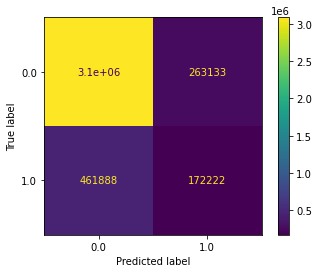

               precision    recall  f1-score   support

non-highlight       0.87      0.92      0.89   3349971
    highlight       0.40      0.27      0.32    634110

     accuracy                           0.82   3984081
    macro avg       0.63      0.60      0.61   3984081
 weighted avg       0.79      0.82      0.80   3984081



In [31]:
eval_results(pred, total_hl_data)

In [28]:
col1 = np.concatenate([total_hl_data, pred])
col2 = np.concatenate([["highlight"]*len(total_hl_data),["prediction"]*len(pred)])
col3 = range(len(pred)*2)

In [25]:
col1.shape, col2.shape, len(col3)

((6717862,), (6717862,), 6717862)

In [26]:
plot_data = zip(col1, col2, col3)

In [27]:
df_plot = pd.DataFrame(plot_data, columns=["value", "type", "data_point"])

In [28]:
df_plot

,value,type,data_point
0,0.0,highlight,0
1,0.0,highlight,1
2,0.0,highlight,2
3,0.0,highlight,3
4,0.0,highlight,4
...,...,...,...
6717857,0.0,prediction,6717857
6717858,0.0,prediction,6717858
6717859,0.0,prediction,6717859
6717860,0.0,prediction,6717860


In [33]:
df_plot.iloc[:10,:]

,value,type,data_point
0,0.0,highlight,0
1,0.0,highlight,1
2,0.0,highlight,2
3,0.0,highlight,3
4,0.0,highlight,4
5,0.0,highlight,5
6,0.0,highlight,6
7,0.0,highlight,7
8,0.0,highlight,8
9,0.0,highlight,9


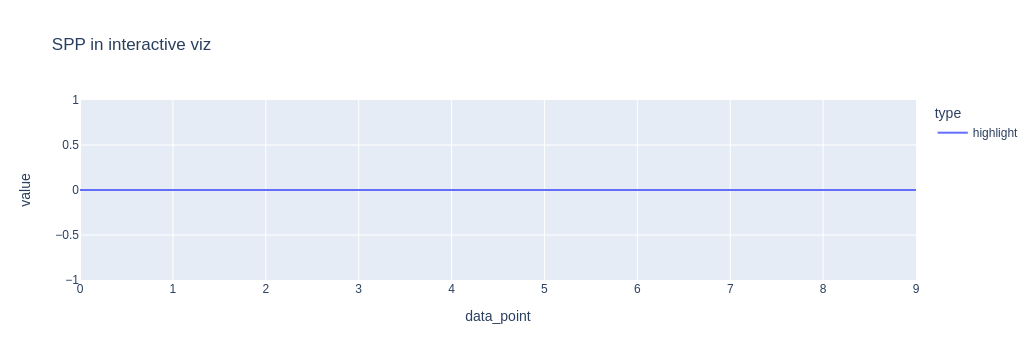

In [34]:
fig = px.line(df_plot.iloc[:10,:], x="data_point", y="value", title='SPP in interactive viz', color="type")
fig.show()

### RealTimePeakPredictor RTPP

In [91]:
with open("../data/baseline_vis_test_data.json", "r") as in_file:
    hl_msg_data = json.load(in_file)

dat = hl_msg_data
matches = list(sorted(hl_msg_data.keys()))

In [92]:
val_matches = list()
val_data = dict()
for m in matches:
    # re_res = re.match("*", m)
    # if re_res:
    val_matches.append(m)
    val_data[m] = hl_msg_data[m]

In [93]:
len(val_matches)

50

In [96]:
cur_params = {
    "lag": 30,
    "threshold": 2.0,
    "influence": 0.7,
}

In [97]:
total_msg_dens = list()
total_hl_data = list()
for n, dat in val_data.items():
    total_msg_dens.extend(dat["msg_dens"])
    total_hl_data.extend(dat["highlights"])
            
pred = RealTimePeakPredictor(**cur_params).predict(total_msg_dens)

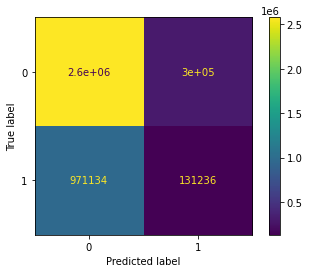

               precision    recall  f1-score   support

non-highlight       0.73      0.89      0.80   2881711
    highlight       0.30      0.12      0.17   1102370

     accuracy                           0.68   3984081
    macro avg       0.51      0.51      0.49   3984081
 weighted avg       0.61      0.68      0.63   3984081



In [98]:
eval_results(pred, total_hl_data)

#### SPP in pipeline

In [23]:
SPP_param_grid = {
        "measure": ["message_density"],
        "window": [150],
        "step": [20]
    }
trn = load_data("train", ch_dir="../data/final_data/", hl_dir="../data/gt/", em_dir="../data/emotes/", param_grid=SPP_param_grid)
i_trn, x_trn, y_trn, p_trn = next(trn)

dval = load_data("val", ch_dir="../data/final_data/", hl_dir="../data/gt/", em_dir="../data/emotes/", param_grid=SPP_param_grid)
i_val, x_val, y_val, p_val = next(dval)

In [26]:
# spp = ScipyPeaks(prominence=0.5, rel_height=0.6, shift=0.3, width=[5, 2000])
spp = Pipeline([("avg", FunctionTransformer(moving_avg, kw_args={"N": 50})),
                       ("scaler", MinMaxScaler()),
                       ("clf", ScipyPeaks(prominence=0.5, rel_height=0.6, shift=0.3, width=[5, 2000]))
                     ])

In [31]:
spp.fit(x_trn.reshape(-1,1))

Pipeline(steps=[('avg',
                 FunctionTransformer(func=<function moving_avg at 0x7f45c92aa4c0>,
                                     kw_args={'N': 50})),
                ('scaler', MinMaxScaler()),
                ('clf', <ScipyPeaks.ScipyPeaks object at 0x7f45c7cefd00>)])

In [32]:
y_pred = spp.predict(x_val.reshape(-1,1))

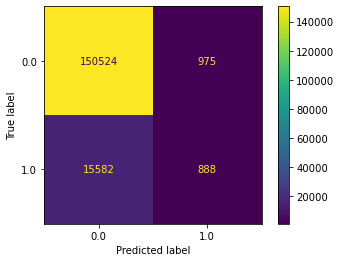

               precision    recall  f1-score   support

non-highlight       0.91      0.99      0.95    151499
    highlight       0.48      0.05      0.10     16470

     accuracy                           0.90    167969
    macro avg       0.69      0.52      0.52    167969
 weighted avg       0.86      0.90      0.86    167969



In [33]:
eval_results(y, y_pred)

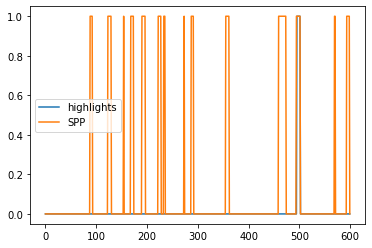

In [51]:
plt.plot(y[:600], label="highlights")
plt.plot(y_pred[:600], label="SPP")
plt.legend()
plt.show()

### Real time peak predictor

#### RTPP in pipeline

In [20]:
RTPP_param_grid = {
        "measure": ["message_density"],
        "window": [200],
        "step": [40]
    }
trn = load_data("train", ch_dir="../data/final_data/", hl_dir="../data/gt/", em_dir="../data/emotes/", param_grid=RTPP_param_grid)
i_trn, x_trn, y_trn, p_trn = next(trn)

dval = load_data("val", ch_dir="../data/final_data/", hl_dir="../data/gt/", em_dir="../data/emotes/", param_grid=RTPP_param_grid)
i_val, x_val, y_val, p_val = next(dval))

dval = load_data("test", ch_dir="../data/final_data/", hl_dir="../data/gt/", em_dir="../data/emotes/", param_grid=RTPP_param_grid)
i_val, x_val, y_val, p_val = next(dval))

In [34]:
rtpp = Pipeline([("avg", FunctionTransformer(moving_avg, kw_args={"N": 5})),
                       ("scaler", MinMaxScaler()),
                       ("clf", RealTimePeakPredictor(influence=0.7, lag=35, threshold=2))
                     ])

In [36]:
rtpp.fit(x_trn.reshape(-1,1))

Pipeline(steps=[('avg',
                 FunctionTransformer(func=<function moving_avg at 0x7f45c92aa4c0>,
                                     kw_args={'N': 5})),
                ('scaler', MinMaxScaler()),
                ('clf',
                 <RealTimePeakPredictor.RealTimePeakPredictor object at 0x7f4578652d30>)])

In [37]:
y_pred = rtpp.predict(x_val.reshape(-1,1))

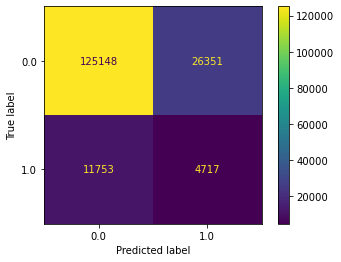

               precision    recall  f1-score   support

non-highlight       0.91      0.83      0.87    151499
    highlight       0.15      0.29      0.20     16470

     accuracy                           0.77    167969
    macro avg       0.53      0.56      0.53    167969
 weighted avg       0.84      0.77      0.80    167969



In [38]:
eval_results(y, y_pred)

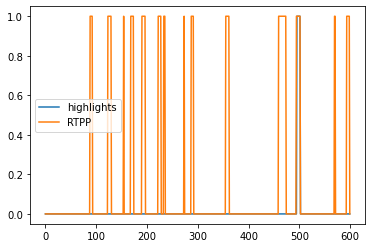

In [53]:
plt.plot(y[:600], label="highlights")
plt.plot(y_pred[:600], label="RTPP")
plt.legend()
plt.show()

## Text classifiers

### Data loading

In [15]:
def chat_hl_to_documents(ch_match, hl_match, step=30, frames_per_doc=210, hl_threshold=0.5, offset=0):
    # make non-overlapping windows of frames_per_doc/30 seconds
    # TODO: implement offset to adjust for comment lag
    # chm = [ch_match[i:i+frames_per_doc] for i in range(0,len(ch_match), frames_per_doc)]
    # hlm = [hl_match[i:i+frames_per_doc] for i in range(0,len(hl_match), frames_per_doc)]
    
    chm = [ch_match[i:i+frames_per_doc] for i in range(0,len(ch_match), step)]
    hlm = [hl_match[i:i+frames_per_doc] for i in range(0,len(hl_match), step)]
    
    chm_docs = list()
    hlm_docs = list()
    
    for m_doc, h_doc in zip(chm, hlm):
        chm_docs.append(re.sub("\n+", " ", "".join(m_doc)).strip().lower())
        hlm_docs.append(h_doc[0])
        # chm_docs.append("".join(m_doc))
        # hlm_docs.append(int(sum(h_doc) >= hl_threshold))
        
    
    return chm_docs, hlm_docs

In [16]:
def shuffle_two_iters(a1, a2, rng_seed=42):
    # shuffles two iterables in the same way and turns them into numpy arrays
    shuffle_inds = list(range(len(a1)))
    np.random.default_rng(rng_seed).shuffle(shuffle_inds)
    
    ret1 = np.asarray(a1)[shuffle_inds]
    ret2 = np.asarray(a2)[shuffle_inds]
    return ret1, ret2

In [17]:
def load_train_val_docs(mode="train", load_random=5, random_state=42, shuffle=True, frames_per_doc=120, hl_threshold=0.5, offset=0):    
    if mode == "train":
        file_regex = "nalcs_w[134579]*_g[13]" # weeks 1,3,4,5,7,9 games 1 and 3 of each match for training
    if mode == "val":
        file_regex = "nalcs_w[1-4]*_g[2]" # weeks 2,6,8 games 1 and 3 of each match for validation
    if mode == "test":
        file_regex = "nalcs_w[5-9]*_g[2]" # weeks 2,6,8 games 1 and 3 of each match for validation


    chat = load_chat("../data/final_data", load_random=load_random, random_state=random_state, file_identifier=file_regex)
    highlights = load_highlights("../data/gt", file_identifier=file_regex)

    remove_missing_matches(chat, highlights)

    chat_docs = list()
    hl_docs = list()

    for match in chat.keys():
        ch_match, hl_match = cut_same_length(chat[match], highlights[match])
        cd, hd  = chat_hl_to_documents(ch_match, hl_match, frames_per_doc=frames_per_doc, hl_threshold=hl_threshold, offset=offset)
        # put all documents together
        chat_docs.extend(cd)
        hl_docs.extend(hd)

    # garbage collect chat and highlights    
    
    if shuffle:
        chat_docs, hl_docs = shuffle_two_iters(chat_docs, hl_docs)
        
    return chat_docs, hl_docs

In [18]:
def balance_data_parallel(x, y, strategy="oversample"):
    x_pos = x[y == 1]
    y_pos = y[y == 1]
    x_neg = x[y == 0]
    y_neg = y[y == 0]
    if len(y_pos) != len(y_neg):
        x_small = x_pos if len(x_pos) < len(x_neg) else x_neg
        y_small = y_pos if len(y_pos) < len(y_neg) else y_neg
        x_large = x_pos if len(x_pos) >= len(x_neg) else x_neg
        y_large = y_pos if len(y_pos) >= len(y_neg) else y_neg
        
        if strategy == "oversample":            
            repeat_amount = int(len(y_large) / len(y_small))
            len_difference = len(y_large)-len(y_small)*repeat_amount
            x_small_rep = np.concatenate([np.repeat(x_small, repeat_amount), x_small[:len_difference]])
            y_small_rep = np.concatenate([np.repeat(y_small, repeat_amount), y_small[:len_difference]])
            
            x_balanced = np.concatenate([x_small_rep, x_large])
            y_balanced = np.concatenate([y_small_rep, y_large])
        if strategy == "undersample":
            inds_under = np.random.choice(np.arange(len(x_large)), len(x_small), replace=False)
            
            x_large_under = x_large[inds_under]
            y_large_under = y_large[inds_under]
            
            x_balanced = np.concatenate([x_small, x_large_under])
            y_balanced = np.concatenate([y_small, y_large_under])
        
        return shuffle_two_iters(x_balanced, y_balanced)
    else:
        return x, y


In [19]:
ch_train, hl_train = load_train_val_docs(mode="train", frames_per_doc=210, load_random=None, random_state=None)

In [20]:
# load validation data
ch_val, hl_val = load_train_val_docs(mode="val", frames_per_doc=210, load_random=None, random_state=None)

In [21]:
# load test data
x_tst, y_tst = load_train_val_docs(mode="test", frames_per_doc=210, load_random=None, random_state=None)

In [22]:
x_tst.shape

(132829,)

In [23]:
hl_train.shape

(240750,)

In [ ]:
x_val, y_val = balance_data_parallel(ch_val, hl_val, strategy="oversample") # => doesn't make sense
# x_val, y_val = ch_val, hl_val

In [ ]:
x_val.shape

In [ ]:
x_train, y_train = balance_data_parallel(ch_train, hl_train, strategy="oversample")

In [ ]:
x_train = np.concatenate([x_train, x_val])
y_train= np.concatenate([y_train, y_val])

In [ ]:
x_train.shape, x_train.shape

### TFIDF > MultinomialNaiveBayes

In [17]:
text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

In [18]:
text_clf.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

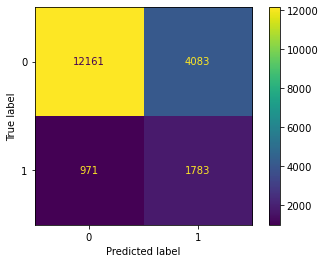

               precision    recall  f1-score   support

non-highlight       0.93      0.75      0.83     16244
    highlight       0.30      0.65      0.41      2754

     accuracy                           0.73     18998
    macro avg       0.62      0.70      0.62     18998
 weighted avg       0.84      0.73      0.77     18998



In [21]:
y_pred = text_clf.predict(x_tst)
eval_results(y_tst, y_pred)

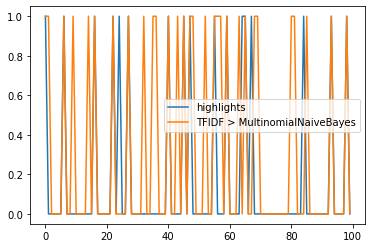

In [22]:
plt.plot(y_tst[1000:1100], label="highlights")
plt.plot(y_pred[1000:1100], label="TFIDF > MultinomialNaiveBayes")
plt.legend()
plt.show()

### Word2Vec > LogisticRegression

In [23]:
LR_clf = Pipeline([
    ('w2v', EmbeddingTransformer("/home/max/git/chat-highlight-detection/data/embeddings/twitch_emote_embedding_all_top1000.kvmodel")),
    ('clf', LogisticRegression(max_iter=1000))
    # ('clf', SVC(kernel="rbf"))
])

In [24]:
LR_clf.fit(x_train, y_train)

Pipeline(steps=[('w2v',
                 EmbeddingTransformer(model=<gensim.models.keyedvectors.Word2VecKeyedVectors object at 0x7f4b1bf0fa60>)),
                ('clf', LogisticRegression(max_iter=1000))])

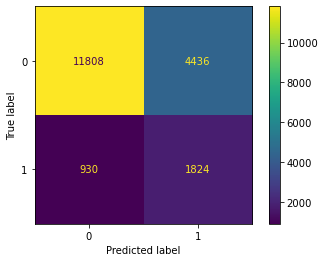

               precision    recall  f1-score   support

non-highlight       0.93      0.73      0.81     16244
    highlight       0.29      0.66      0.40      2754

     accuracy                           0.72     18998
    macro avg       0.61      0.69      0.61     18998
 weighted avg       0.83      0.72      0.76     18998



In [25]:
y_pred = LR_clf.predict(x_tst)
eval_results(y_tst, y_pred)

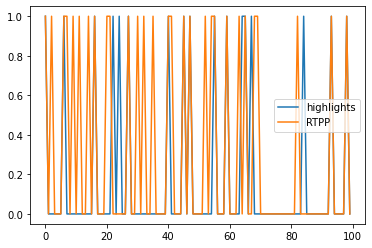

In [26]:
plt.plot(y_tst[1000:1100], label="highlights")
plt.plot(y_pred[1000:1100], label="RTPP")
plt.legend()
plt.show()